<a href="https://colab.research.google.com/github/Miragecore/SandBox/blob/devel/Colab/Stitching/stitching_frame_by_frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#드라이브안에서 프로젝트 드라이브로 이동
import os;
root_path = '/content/drive/MyDrive/SandBox/Stitch/earring'

os.chdir(root_path);

print(os.getcwd())

/content/drive/MyDrive/SandBox/Stitch/earring


In [3]:
#from IPython.display import Image, display
import cv2, numpy as np

#Colab에서 imShow를 사용하기 위해 cv2_imshow를 사용한다.
from google.colab.patches import cv2_imshow

#SIFT or SURF는 4.3이상의 버전에서만 사용가능하다. 
if cv2.__version__ != "4.4.0":
  print(cv2.__version__)
  #설치후에는 런타임을 재시작해줘야 한다.
  !pip install opencv-contrib-python==4.4.0.44


In [141]:
#먼저 업로드해둔 이미지 파일들
image_files = [
    'earring_1.jpg',
    'earring_2.jpg',
    'earring_3.jpg']

img1 = cv2.imread(image_files[0])
img2 = cv2.imread(image_files[1])
img3 = cv2.imread(image_files[2])

#cv2_imshow(img1)
#cv2_imshow(img2)
#cv2_imshow(img3)

In [142]:
#원본의 그레이 이미지의 복사본을 리턴
def GetGrayImage(img):
  if len(img.shape) > 2:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else :
    return img.copy()
  

In [143]:
#image의 외곽 좌표를 np.array로 리턴
def GetImageCorner(img):
  h, w = img.shape[:2]
  return np.float32([ [0,0],[0,h],[w,h],[w,0]])

In [151]:
#이미지 코너로 바운딩 박스 리턴
#[y, x, height, width] ROI 설정시 순서대로
def BoundingBox(corner):
  [xmin, ymin] = np.int32(corner.min(axis=0).ravel() - 0.5)
  [xmax, ymax] = np.int32(corner.max(axis=0).ravel() + 0.5)
  result_roi = [ymin, xmin,(ymax-ymin), (xmax-xmin)]
  return result_roi

In [181]:
import math

h,w = img1.shape[:2]
result_height = math.floor(h*2.5)
result_width = math.floor(w*2.5)

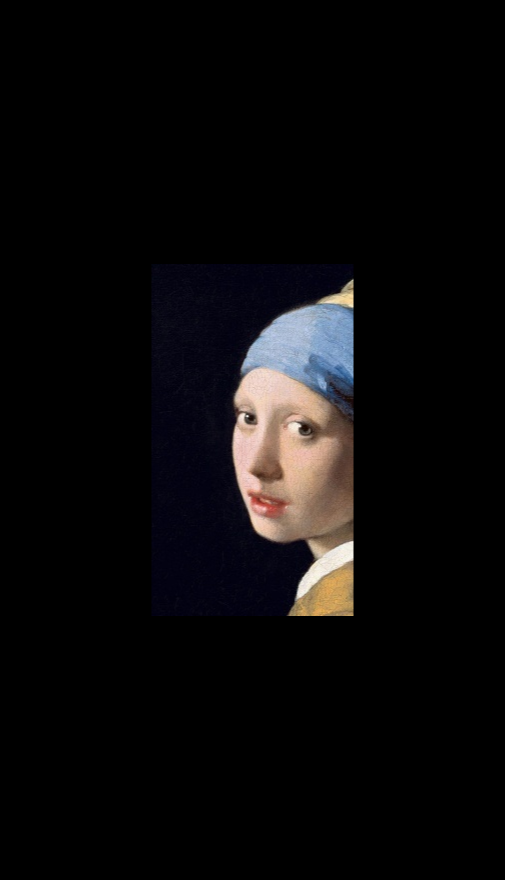

[263, 151, 353, 203]


In [254]:

#이미지 중앙으로 평행 이동
#시작은 결과 이미지 중앙에서
Mt = np.array([[1,0,result_width/2 - w/2], [0,1,result_height/2 - h/2], [0,0,1]],np.float32)

img1_corner = GetImageCorner(img1).reshape(-1,1,2)
img1_tf_corner = cv2.perspectiveTransform(img1_corner, Mt)

#초기 결과 이미지 설정
result_img = cv2.warpPerspective(img1,Mt,(result_width, result_height))
cv2_imshow(result_img)

#초기 ROI 설정
#[x, y, width, height]
result_roi = BoundingBox(img1_tf_corner)
print(result_roi)

#초기 결과 마스크 설정
rg = GetGrayImage(result_img)
_, result_mask = cv2.threshold(rg, 1, 255, cv2.THRESH_BINARY)

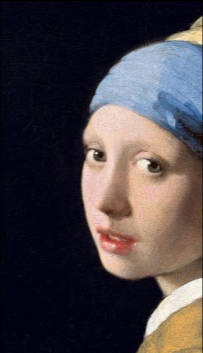

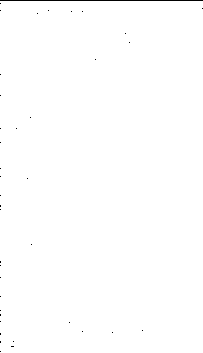

In [255]:
result_roi_img = result_img[result_roi[0]:result_roi[0]+result_roi[2],\
                            result_roi[1]:result_roi[1]+result_roi[3]]
result_roi_mask = result_mask[result_roi[0]:result_roi[0]+result_roi[2],\
                            result_roi[1]:result_roi[1]+result_roi[3]]

cv2_imshow(result_roi_img)
cv2_imshow(result_roi_mask)

In [242]:
#2장의 이미지를 입력 받아서 keypoint와 변환 매트릭스를 리턴
def FindFeature(img1, img2,detector_type = 'SIFT', mask_enable=False,\
               min_match_count = 10):

  detector = None
  if detector_type == 'ORB':
    detector = cv2.ORB_create()
  if detector_type == 'SIFT':
    detector = cv2.SIFT_create()

  #흑백 이미지 생성
  img1_gray = GetGrayImage(img1)
  img2_gray = GetGrayImage(img2)

  #이미지에서 0인 영역으로 마스크를 생성시켜 계산의 속도 향상, 검은 영역이 없다면 무쓸모
  mask1 = None
  mask2 = None
  if(mask_enable):
    _, mask1 = cv2.threshold(img1_gray, 1, 255, cv2.THRESH_BINARY)
    _, mask2 = cv2.threshold(img2_gray, 1, 255, cv2.THRESH_BINARY)

  #keypoint와 Descriptor 찾기
  kp1, desc1 = detector.detectAndCompute(img1_gray, mask1)
  kp2, desc2 = detector.detectAndCompute(img2_gray, mask2)

  return kp1, desc1, kp2, desc2

In [243]:
#변환 찾기가 가능한 최소수 4
MIN_MATCH_COUNT = 4

kp1, desc1, kp2, desc2 = FindFeature(result_roi_img, img2, \
                                     min_match_count = MIN_MATCH_COUNT)
'''
sift_keypointsIm = cv2.drawKeypoints(img1, kp1, \
                                     outImage = cv2.DRAW_MATCHES_FLAGS_DEFAULT,\
                                     color=(0,0,255))

cv2_imshow(sift_keypointsIm)
'''

'\nsift_keypointsIm = cv2.drawKeypoints(img1, kp1,                                      outImage = cv2.DRAW_MATCHES_FLAGS_DEFAULT,                                     color=(0,0,255))\n\ncv2_imshow(sift_keypointsIm)\n'

In [244]:
#Descriptor를 비교하여 매치 상태가 좋은 점들만 리턴
def FindGoodMatch(desc1, desc2, matcher_type = 'FLANN', best_match_count = 2, \
          match_dist = 0.7):
  #FLANN MATCHER로 매치 및 굿 피처 필터링

  matcher = None
  if matcher_type == 'FLANN':
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
  if matcher_type == 'BF':
    matcher = cv2.BFMatcher()

  matches = matcher.knnMatch(desc1,desc2,best_match_count)

  # 2번째 후보와 거리가 0.7 이상인 포인트를 좋은 매치로 분류
  good = []
  for m,n in matches:
      if m.distance < match_dist *n.distance:
          good.append(m)

  return good
  

In [245]:
good_matches = FindGoodMatch(desc1, desc2)

if len(good_matches)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])\
    .reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])\
    .reshape(-1,1,2)


#img2 를 img1으로 변환 할 것이기 때문에
M, RANSAC_mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0)

In [246]:
def addROI(source, warped):
  return [source[0]+warped[0], source[1] + warped[1], warped[2],warped[3]]

[[[285.06152 265.63766]]

 [[285.02588 634.0262 ]]

 [[468.13345 634.2933 ]]

 [[467.53506 263.96198]]]
[263, 151, 370, 317]


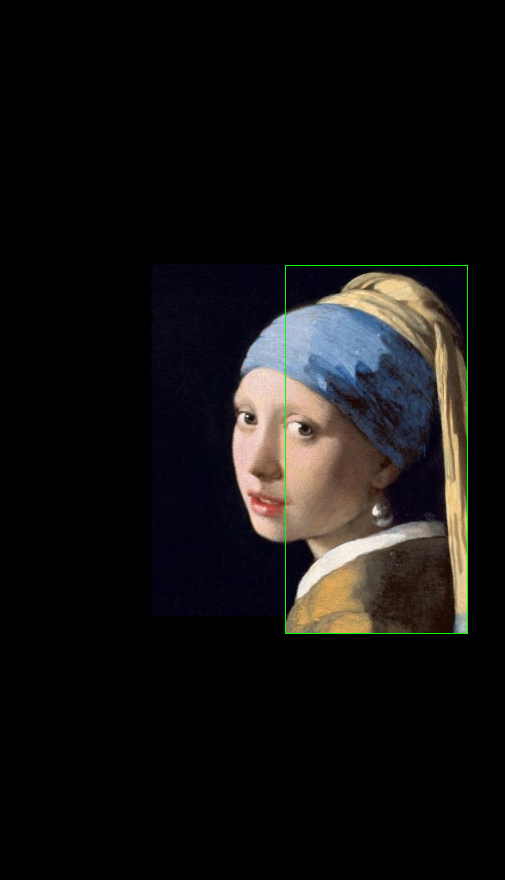

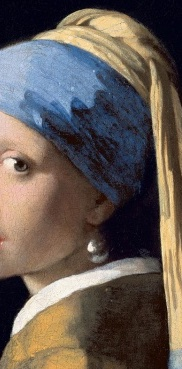

In [269]:
tM = Mt.dot(M)
img2_corner = GetImageCorner(img2).reshape(-1,1,2)
img2_tf_corner = cv2.perspectiveTransform(img2_corner, M)
img2_atf_corner = cv2.perspectiveTransform(img2_corner, tM)



print(img2_atf_corner)

source_corner = GetImageCorner(result_roi_img).reshape(-1,1,2)
corner_after_tr = np.concatenate((source_corner, img2_tf_corner), axis=0)

nROI = BoundingBox(corner_after_tr)
aa = addROI(result_roi, nROI)
print(aa)
warp_img = cv2.warpPerspective(img2,M,(nROI[3], nROI[2]))

#print(aa)
#print(result_roi)
#print(nROI)

result_img_roi = result_img[aa[0]:aa[0]+aa[2], aa[1]:aa[1]+aa[3]]
result_mask_roi = result_mask[aa[0]:aa[0]+aa[2], aa[1]:aa[1]+aa[3]]

warpedGray = GetGrayImage(warp_img)
_, mask = cv2.threshold(warpedGray, 0, 255, cv2.THRESH_BINARY)

kernel = np.ones((5,5),np.uint8)
k1 = (kernel == 1).astype('uint8')

#Result Mask 기반 합성으로 변경 필요
#mask dilate후에 작업

mask = cv2.erode(mask, k1, borderType=cv2.BORDER_CONSTANT)
mask_inv = cv2.bitwise_not(mask);

difference = cv2.bitwise_or(result_img_roi, result_img_roi, mask=mask_inv)
result2 = cv2.bitwise_and(warp_img, warp_img, mask=mask)

t_result_img = result_img.copy()
t_result_img[aa[0]:aa[0]+aa[2], aa[1]:aa[1]+aa[3],:] = \
cv2.add(difference, result2)

#cv2_imshow(result_img_roi)
#cv2_imshow(result_mask_roi)
#cv2_imshow(warp_img)
#new ROI 설정시
tt_roi = t_result_img[265:265+369, 285:285+300]
cv2.rectangle(tt_roi, (0,0), (182, 368), (0,255,0)) # roi 전체에 사각형 그리기 ---②

cv2_imshow(t_result_img)
cv2_imshow(img2)

#새로운 부분만 붙일 것인가
#새로운 부분 전체를 붙일 것인가?

#마지막 추가된 영역으로 ROI 변경
#결과 이미지에 최종 추가된 영역 마스크 변경